# Particle Swarm Optimization (PSO) to tune or improve models

In [4]:
pip install pyswarm tensorflow

Note: you may need to restart the kernel to use updated packages.


## 1. vgg19

Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


I0000 00:00:1749738681.270033     847 service.cc:148] XLA service 0x7ae6ac003570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749738681.270091     847 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749738681.270097     847 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749738683.028497     847 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749738694.867572     847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[lr=0.00216, dropout=0.28] → val_acc=0.9531
[lr=0.00879, dropout=0.69] → val_acc=0.9219
[lr=0.00141, dropout=0.42] → val_acc=0.9531
[lr=0.00753, dropout=0.30] → val_acc=0.9219
[lr=0.00028, dropout=0.33] → val_acc=0.8750
[lr=0.00684, dropout=0.34] → val_acc=0.9219
[lr=0.00907, dropout=0.27] → val_acc=0.9219
[lr=0.00737, dropout=0.59] → val_acc=0.9219
[lr=0.00001, dropout=0.20] → val_acc=1.0000
[lr=0.00634, dropout=0.39] → val_acc=0.9219
[lr=0.00408, dropout=0.59] → val_acc=0.9219
[lr=0.00284, dropout=0.25] → val_acc=0.8906
[lr=0.00127, dropout=0.20] → val_acc=0.9688
[lr=0.00551, dropout=0.27] → val_acc=0.9219
[lr=0.00183, dropout=0.29] → val_acc=0.9531
[lr=0.00709, dropout=0.63] → val_acc=0.9219
[lr=0.00001, dropout=0.20] → val_acc=0.0000
[lr=0.00404, dropout=0.29] → val_acc=0.9219
[lr=0.00356, dropout=0.46] → val_acc=0.9219
[lr=0.00112, dropout=0.22] → val_acc=0.9531
[lr=0.00160, dropout=0.20] → val_acc=0.9531
[lr=0.00429, dropout=0.22] → val_acc=0.9219
[lr=0.00001, dropout=0.30] → val

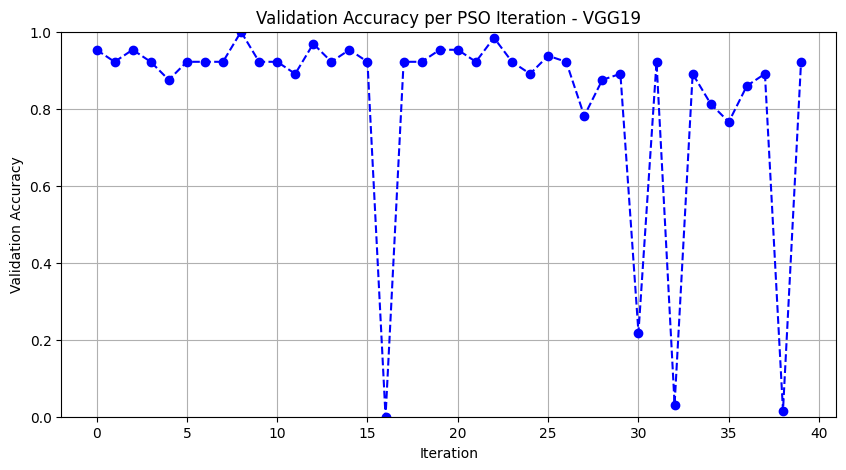

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso
import numpy as np

# === PATHS === #
dataset_path = '/kaggle/input/kidney-img-scans/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
models = {
    'vgg19': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/vgg19_kidney_model.h5',
    'resnet50': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/final_resnet50_model.h5',
    'inceptionv3': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/inception_v3_kidney_model.h5'
}

# === SELECT MODEL TO OPTIMIZE === #
model_name = 'vgg19'  
model_path = models[model_name]
target_size = (299, 299)  

# === IMAGE GENERATOR === #
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes
iteration_scores = []  #  Track accuracy over time

# === OBJECTIVE FUNCTION === #
def objective(params):
    lr, dropout = params
    try:
        base_model = load_model(model_path)
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(dropout),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            steps_per_epoch=5,
            validation_steps=2,
            epochs=2,
            verbose=0
        )

        val_acc = history.history['val_accuracy'][-1]
        iteration_scores.append(val_acc)
        print(f"[lr={lr:.5f}, dropout={dropout:.2f}] → val_acc={val_acc:.4f}")
        return 1 - val_acc

    except Exception as e:
        print(f" Error: {e}")
        iteration_scores.append(0)
        return 1.0

# === PSO RUN === #
lower_bounds = [1e-5, 0.2]   # learning_rate, dropout
upper_bounds = [1e-2, 0.7]

best_params, best_score = pso(objective, lower_bounds, upper_bounds,
                              swarmsize=8, maxiter=4)

# === RESULTS === #
best_val_acc = 1 - best_score
print("\n BEST CONFIGURATION")
print(f"• Model         : {model_name.upper()}")
print(f"• Learning Rate : {best_params[0]:.5f}")
print(f"• Dropout Rate  : {best_params[1]:.2f}")
print(f"• Val Accuracy  : {best_val_acc:.4f}")

# === PLOT ACCURACY OVER ITERATIONS === #
plt.figure(figsize=(10, 5))
plt.plot(iteration_scores, marker='o', linestyle='--', color='b')
plt.title(f'Validation Accuracy per PSO Iteration - {model_name.upper()}')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.ylim(0, 1)
plt.show()


## 2. resnet50 

Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
[lr=0.00212, dropout=0.40] → val_acc=0.8906
[lr=0.00050, dropout=0.20] → val_acc=0.8906
[lr=0.00592, dropout=0.38] → val_acc=0.9219
[lr=0.00403, dropout=0.28] → val_acc=0.9062
[lr=0.00864, dropout=0.33] → val_acc=0.9219
[lr=0.00919, dropout=0.38] → val_acc=0.9219
[lr=0.00409, dropout=0.63] → val_acc=0.9062
[lr=0.00123, dropout=0.68] → val_acc=0.9688
[lr=0.00309, dropout=0.23] → val_acc=0.9219
[lr=0.00001, dropout=0.23] → val_acc=1.0000
[lr=0.00022, dropout=0.41] → val_acc=0.0000
[lr=0.00731, dropout=0.34] → val_acc=0.9219
[lr=0.00353, dropout=0.55] → val_acc=0.9219
[lr=0.00944, dropout=0.20] → val_acc=0.9219
[lr=0.00148, dropout=0.61] → val_acc=0.9688
[lr=0.00513, dropout=0.69] → val_acc=0.9219
[lr=0.00320, dropout=0.20] → val_acc=0.9531
[lr=0.00001, dropout=0.24] → val_acc=0.7812
[lr=0.00001, dropout=0.41] → val_acc=0.0312
[lr=0.00763, dropout=0.33] → val_acc=0.9219
[lr=0.00064, dropout=0.59] → val_acc

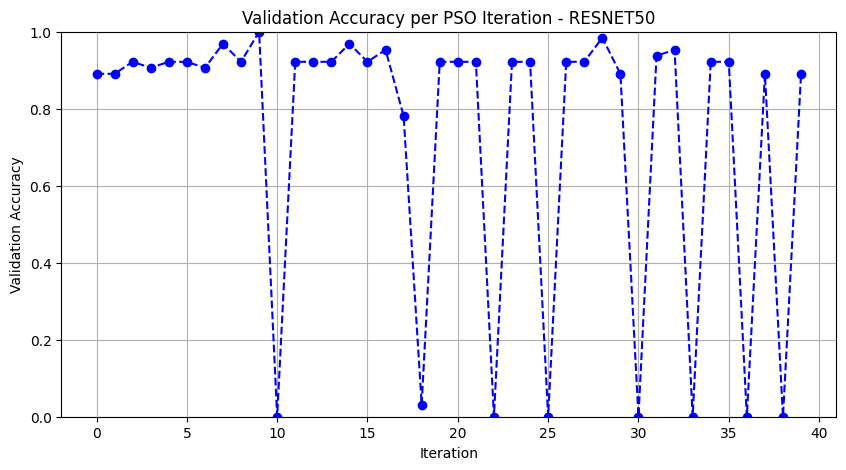

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso
import numpy as np

# === PATHS === #
dataset_path = '/kaggle/input/kidney-img-scans/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
models = {
    'vgg19': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/vgg19_kidney_model.h5',
    'resnet50': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/final_resnet50_model.h5',
    'inceptionv3': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/inception_v3_kidney_model.h5'
}

# === SELECT MODEL TO OPTIMIZE === #
model_name = 'resnet50'  
model_path = models[model_name]
target_size = (299, 299)

# === IMAGE GENERATOR === #
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes
iteration_scores = []  #  Track accuracy over time

# === OBJECTIVE FUNCTION === #
def objective(params):
    lr, dropout = params
    try:
        base_model = load_model(model_path)
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(dropout),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            steps_per_epoch=5,
            validation_steps=2,
            epochs=2,
            verbose=0
        )

        val_acc = history.history['val_accuracy'][-1]
        iteration_scores.append(val_acc)
        print(f"[lr={lr:.5f}, dropout={dropout:.2f}] → val_acc={val_acc:.4f}")
        return 1 - val_acc

    except Exception as e:
        print(f" Error: {e}")
        iteration_scores.append(0)
        return 1.0

# === PSO RUN === #
lower_bounds = [1e-5, 0.2]   # learning_rate, dropout
upper_bounds = [1e-2, 0.7]

best_params, best_score = pso(objective, lower_bounds, upper_bounds,
                              swarmsize=8, maxiter=4)

# === RESULTS === #
best_val_acc = 1 - best_score
print("\n BEST CONFIGURATION")
print(f"• Model         : {model_name.upper()}")
print(f"• Learning Rate : {best_params[0]:.5f}")
print(f"• Dropout Rate  : {best_params[1]:.2f}")
print(f"• Val Accuracy  : {best_val_acc:.4f}")

# === PLOT ACCURACY OVER ITERATIONS === #
plt.figure(figsize=(10, 5))
plt.plot(iteration_scores, marker='o', linestyle='--', color='b')
plt.title(f'Validation Accuracy per PSO Iteration - {model_name.upper()}')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.ylim(0, 1)
plt.show()


## 3. inceptionv3 

Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
[lr=0.00564, dropout=0.58] → val_acc=0.9688
[lr=0.00283, dropout=0.21] → val_acc=0.9688
[lr=0.00889, dropout=0.65] → val_acc=0.9375
[lr=0.00190, dropout=0.64] → val_acc=0.9375
[lr=0.00692, dropout=0.58] → val_acc=0.9531
[lr=0.00186, dropout=0.39] → val_acc=0.9531
[lr=0.00601, dropout=0.24] → val_acc=0.9531
[lr=0.00328, dropout=0.67] → val_acc=0.9531
[lr=0.00368, dropout=0.35] → val_acc=0.9688
[lr=0.00056, dropout=0.44] → val_acc=0.9219
[lr=0.00945, dropout=0.67] → val_acc=0.9531
[lr=0.00587, dropout=0.70] → val_acc=0.9219
[lr=0.00472, dropout=0.58] → val_acc=0.9531
[lr=0.00001, dropout=0.44] → val_acc=0.0000
[lr=0.00597, dropout=0.20] → val_acc=0.9219
[lr=0.00576, dropout=0.55] → val_acc=0.9219
[lr=0.00335, dropout=0.39] → val_acc=0.9375
[lr=0.00186, dropout=0.59] → val_acc=0.9688
[lr=0.00803, dropout=0.66] → val_acc=0.9531
[lr=0.00656, dropout=0.70] → val_acc=0.9531
[lr=0.00444, dropout=0.58] → val_acc

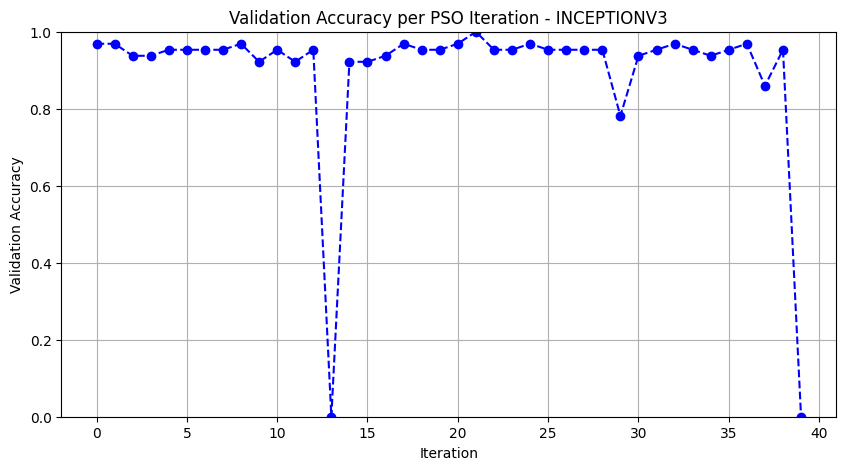

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso
import numpy as np

# === PATHS === #
dataset_path = '/kaggle/input/kidney-img-scans/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
models = {
    'vgg19': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/vgg19_kidney_model.h5',
    'resnet50': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/final_resnet50_model.h5',
    'inceptionv3': '/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/inception_v3_kidney_model.h5'
}

# === SELECT MODEL TO OPTIMIZE === #
model_name = 'inceptionv3'  #  Choose: 'resnet50' or 'inceptionv3'
model_path = models[model_name]
target_size = (299, 299)  #  All your models expect this

# === IMAGE GENERATOR === #
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes
iteration_scores = []  #  Track accuracy over time

# === OBJECTIVE FUNCTION === #
def objective(params):
    lr, dropout = params
    try:
        base_model = load_model(model_path)
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(dropout),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            steps_per_epoch=5,
            validation_steps=2,
            epochs=2,
            verbose=0
        )

        val_acc = history.history['val_accuracy'][-1]
        iteration_scores.append(val_acc)
        print(f"[lr={lr:.5f}, dropout={dropout:.2f}] → val_acc={val_acc:.4f}")
        return 1 - val_acc

    except Exception as e:
        print(f" Error: {e}")
        iteration_scores.append(0)
        return 1.0

# === PSO RUN === #
lower_bounds = [1e-5, 0.2]   # learning_rate, dropout
upper_bounds = [1e-2, 0.7]

best_params, best_score = pso(objective, lower_bounds, upper_bounds,
                              swarmsize=8, maxiter=4)

# === RESULTS === #
best_val_acc = 1 - best_score
print("\n BEST CONFIGURATION")
print(f"• Model         : {model_name.upper()}")
print(f"• Learning Rate : {best_params[0]:.5f}")
print(f"• Dropout Rate  : {best_params[1]:.2f}")
print(f"• Val Accuracy  : {best_val_acc:.4f}")

# === PLOT ACCURACY OVER ITERATIONS === #
plt.figure(figsize=(10, 5))
plt.plot(iteration_scores, marker='o', linestyle='--', color='b')
plt.title(f'Validation Accuracy per PSO Iteration - {model_name.upper()}')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.ylim(0, 1)
plt.show()


# Testing

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
# Load models
vgg19_model = load_model("/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/vgg19_kidney_model.h5")
resnet_model = load_model("/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/final_resnet50_model.h5")
inception_model = load_model("/kaggle/input/vgg19_resnet50_inceptionv3/tensorflow1/default/1/inception_v3_kidney_model.h5")

# Confirm model input shapes
print("Model input shapes:")
print("VGG19 input shape:", vgg19_model.input_shape)
print("ResNet50 input shape:", resnet_model.input_shape)
print("InceptionV3 input shape:", inception_model.input_shape)

# Class labels
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Prediction function
def predict_image(image_bytes):
    image_bytes.seek(0)
    original_img = Image.open(image_bytes).convert('RGB')

    # Resize all images to 299x299 (Inception requirement)
    img_resized = original_img.resize((299, 299))
    input_array = np.expand_dims(np.array(img_resized), axis=0)

    # Preprocess for InceptionV3
    input_incep = inception_preprocess(input_array.copy())

    # Normalize for VGG19 and ResNet50
    input_vgg_resnet = input_array / 255.0

    print("Input shape for all models:", input_array.shape)

    # Run predictions
    vgg_pred = vgg19_model.predict(input_vgg_resnet)[0]
    resnet_pred = resnet_model.predict(input_vgg_resnet)[0]
    incep_pred = inception_model.predict(input_incep)[0]

    results = {
        "VGG19": (class_names[np.argmax(vgg_pred)], np.max(vgg_pred)),
        "ResNet50": (class_names[np.argmax(resnet_pred)], np.max(resnet_pred)),
        "InceptionV3": (class_names[np.argmax(incep_pred)], np.max(incep_pred)),
    }

    return results, img_resized

# UI Components
uploader = widgets.FileUpload(accept='image/*', multiple=False)
predict_button = widgets.Button(description="Predict", button_style='success')
output_box = widgets.Output()

# Click event handler
def on_predict_clicked(b):
    with output_box:
        clear_output()
        if len(uploader.value) == 0:
            print("Please upload an image first!")
            return

        file_info = uploader.value[0]
        image_bytes = io.BytesIO(file_info['content'])

        results, img_resized = predict_image(image_bytes)

        # Show image
        plt.imshow(img_resized)
        plt.axis('off')
        plt.title("Uploaded Image")
        plt.show()

        # Show predictions
        for model_name, (label, confidence) in results.items():
            print(f"{model_name}: {label} ({confidence:.2%} confidence)")

# Bind event
predict_button.on_click(on_predict_clicked)

# Show UI
display(widgets.VBox([uploader, predict_button, output_box]))

Model input shapes:
VGG19 input shape: (None, 299, 299, 3)
ResNet50 input shape: (None, 299, 299, 3)
InceptionV3 input shape: (None, 299, 299, 3)
